In [1]:
# In this notebook:

# clean up the dataset for better clustering
# guess and label game titles for visualization
# utilize pivot tables for calculations
# attempt K-means and Agglomerative clustering to group games

# Results: K-Means clustering was pretty successful at grouping games by genre

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)

In [4]:
gorig = pd.read_csv('amazon_games_clean.csv',index_col=0)

print(f'Dataset has {gorig.shape[0]} samples')

gorig.head()

Dataset has 98144 samples


,asin,helppercent,overall,cleansum,cleantxt,cleanboth
0,0700099867,0.666667,1,pay unlock content dont think,instal game wa struggle game window live championship race car unlock buy addon game pay nearly ...,pay unlock content dont think instal game wa struggle game window live championship race car unl...
1,0700099867,0.700000,3,awesome game crash frequently,get version instead p version turn mistake console version game look percent good pc version dea...,awesome game crash frequently get version instead p version turn mistake console version game lo...
2,0700099867,1.000000,4,dirt,dirt xbox wa okay game start play game laptop buy new game build collection game fun play much b...,dirt dirt xbox wa okay game start play game laptop buy new game build collection game fun play m...
3,0700099867,0.846154,5,step dirt terrific,love play dirt think graphic good purchase dirt addition otherand graphic absolutely gorgeous li...,step dirt terrific love play dirt think graphic good purchase dirt addition otherand graphic abs...
4,0700099867,1.000000,2,couldnt get one work,still havent figure one everything instruct game never instal strange since dont like rate somet...,couldnt get one work still havent figure one everything instruct game never instal strange since...


In [5]:
gorig.fillna(value='filler', inplace=True)

gorig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98144 entries, 0 to 98143
Data columns (total 6 columns):
asin           98144 non-null object
helppercent    98144 non-null float64
overall        98144 non-null int64
cleansum       98144 non-null object
cleantxt       98144 non-null object
cleanboth      98144 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


In [6]:
vc_asin = gorig['asin'].value_counts()
vc_asin = vc_asin[(vc_asin >= 50) & (vc_asin <= 65)]

print(f'Unique games with 50~65 reviews: {len(vc_asin)}')

Unique games with 50~65 reviews: 93


In [7]:
# this gives us a better population for clustering
gedit = gorig[gorig['asin'].isin(list(vc_asin.index))]
gedit.reset_index(drop=True, inplace=True)

print(f'Dataset size of 50~65 reviews games: {gedit.shape[0]}')
print(f"Dataset unique word size is: {len(pd.Series(' '.join(gedit['cleanboth']).split()).value_counts())}")

Dataset size of 50~65 reviews games: 5205
Dataset unique word size is: 24322


## Remove frequent and rare words for better clustering

In [8]:
# non-distinguishing but frequent words like 'game' can affect clustering
both_words = pd.Series(' '.join(gedit['cleanboth']).split()).value_counts()

both_words[:30]

game         35060
play         10191
get           9275
wa            8563
like          8500
one           7136
time          6213
make          5761
ha            5026
go            4868
really        4674
good          4196
great         4126
much          4049
fun           3748
use           3716
new           3707
story         3697
even          3689
dont          3620
character     3534
thing         3532
also          3479
take          3474
first         3432
would         3221
well          3169
say           3153
look          3122
find          3088
dtype: int64

In [9]:
freq_words = both_words[(both_words >= 3000)]
rare_words = both_words[(both_words <= 3)]

print(f'Freq word size: {len(freq_words)}')
print(f'Rare word size: {len(rare_words)}')

Freq word size: 30
Rare word size: 15058


In [10]:
# removing sentiment words by choice as they skew clusters
sentiment_words = ['good','bad','great','terrible','love','hate','awesome','really','much']

In [11]:
gedit['cleanboth'] = gedit['cleanboth'].apply(lambda x: " ".join(x for x in str(x).split() if x not in freq_words))
gedit['cleanboth'] = gedit['cleanboth'].apply(lambda x: " ".join(x for x in str(x).split() if x not in rare_words))
gedit['cleanboth'] = gedit['cleanboth'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sentiment_words))
gedit['cleanboth'] = gedit['cleanboth'].apply(lambda x: " ".join(x for x in str(x).split() if len(x) > 1))

gedit.head()

,asin,helppercent,overall,cleansum,cleantxt,cleanboth
0,B00000DMB3,1.000000,5,love game,love game love game love game get ocarina time year since ha come still rock even comparison wha...,ocarina year since come still rock comparison whats ive playstation couple year ocarina realize ...
1,B00000DMB3,1.000000,5,true classic,game blow away didnt expect ocarina meet standard play previous zelda game usually go stale pred...,true classic blow away didnt expect ocarina meet standard previous zelda usually stale predictab...
2,B00000DMB3,0.666667,5,timeless classic,im gamers call zelda veteran ive play almost zelda game manage beat one one love zelda game chal...,timeless classic im gamers call zelda veteran ive almost zelda manage beat zelda challenge diffe...
3,B00000DMB3,1.000000,5,one n game must,follow lineage zelda early day classic bite system onward snes day quota link pastquot great gam...,must follow zelda early day classic bite system onward snes day quota link pastquot every second...
4,B00000DMB3,0.833333,5,legendary,play game zelda game ever play wa link past couldnt understand well decide play hype wa sure gla...,legendary zelda ever link past couldnt understand decide hype sure glad best ever full adventure...


In [12]:
print(f"Remaining unique word count: {len(pd.Series(' '.join(gedit['cleanboth']).split()).value_counts())}")

Remaining unique word count: 9212


## Game title identification

In [16]:
# utilizing technique from pt 3 to label games

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [26]:
tflab = TfidfVectorizer(max_features=1000000, lowercase=True, analyzer='word',
                        stop_words = 'english', ngram_range=(2,2))

tflabvec = tflab.fit_transform(gedit['cleanboth'])

tflabvec

<5205x409145 sparse matrix of type '<class 'numpy.float64'>'
	with 588354 stored elements in Compressed Sparse Row format>

In [17]:
vocab_lookup = {v:k for k,v in tflab.vocabulary_.items()}

In [18]:
# for guesses with weak confidence, label as bad identifier
asin_label = {}

for i in set(gedit['asin']):
    asin_unique = gedit[gedit['asin'] == i].index
    asin_tfidf = Counter([vocab_lookup[np.argmax(v)] for v in tflabvec[asin_unique]])
    if asin_tfidf.most_common(1)[0][1] > 2:
        asin_label[i] = asin_tfidf.most_common(1)[0][0]
    else:
        asin_label[i] = 'bad identifier'

In [19]:
# visualize game labels
asin_label.values()

dict_values(['god war', 'stop button', 'bad identifier', 'star war', 'bad identifier', 'bad identifier', 'bad identifier', 'modern warfare', 'heavy rain', 'bad identifier', 'world war', 'dragon dogma', 'dead redemption', 'star war', 'zelda ocarina', 'memory card', 'bad identifier', 'bad identifier', 'dead island', 'guild war', 'better xbox', 'sport champion', 'animal cross', 'social link', 'hard drive', 'lose odyssey', 'resident evil', 'twilight princess', 'dead space', 'bad identifier', 'assassin creed', 'skyward sword', 'diablo ii', 'bad identifier', 'lord shadow', 'gear war', 'dragon age', 'charge station', 'dual shock', 'nintendo gamecube', 'wii sport', 'medal honor', 'world war', 'dead rise', 'assassin creed', 'sleep dog', 'squad leader', 'dark soul', 'god war', 'black ops', 'deus ex', 'bad identifier', 'medal honor', 'bioshock infinite', 'kingdom amalur', 'dragon age', 'fallout vega', 'ratchet clank', 'sims sims', 'memory card', 'bad identifier', 'bad identifier', 'mario kart', '

In [21]:
def dict_to_dataframe (x):
    return asin_label[x]

In [22]:
gedit['title'] = gedit['asin'].apply(dict_to_dataframe)

gedit.head(2)

,asin,helppercent,overall,cleansum,cleantxt,cleanboth,title
0,B00000DMB3,1.0,5,love game,love game love game love game get ocarina time year since ha come still rock even comparison wha...,ocarina year since come still rock comparison whats ive playstation couple year ocarina realize ...,legend zelda
1,B00000DMB3,1.0,5,true classic,game blow away didnt expect ocarina meet standard play previous zelda game usually go stale pred...,true classic blow away didnt expect ocarina meet standard previous zelda usually stale predictab...,legend zelda


In [25]:
gedit['title'].value_counts()[:10]

bad identifier    1034
resident evil      179
super mario        178
dragon age         172
assassin creed     163
medal honor        159
memory card        128
world war          119
dead space         112
star war           112
Name: title, dtype: int64

In [29]:
gedit = gedit[gedit['title'] != 'bad identifier']

print(f'Dataset size without bad identifiers: {len(gedit)}')

Dataset size without bad identifiers: 4171


## Cluster Analysis

In [30]:
tf = TfidfVectorizer(max_features=1000000, lowercase=True, analyzer='word',
                     stop_words = 'english', ngram_range=(1,1))

tfvec = tf.fit_transform(gedit['cleanboth'])

tfvec

<4171x8959 sparse matrix of type '<class 'numpy.float64'>'
	with 355388 stored elements in Compressed Sparse Row format>

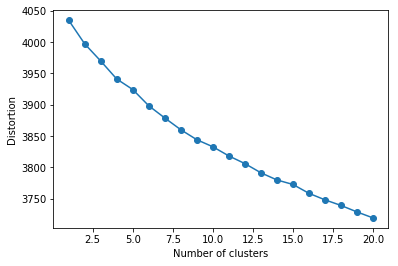

In [31]:
# Kmeans & Elbow Method
from sklearn.cluster import KMeans
distortions = []
for i in range(1, 21):
    km = KMeans(n_clusters=i, init='k-means++',
                n_init=10, max_iter=50, random_state=0)
    km.fit(tfvec)
    distortions.append(km.inertia_)
plt.plot(range(1,21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# we see that ideal clustering isn't achieved within 15 clusters
# not surprising due to sample size and TFIDF length

In [32]:
# we can choose around 15 clusters
km = KMeans(n_clusters=15, init='k-means++',
            n_init=10, max_iter=300, random_state=0)
km_pred = km.fit_predict(tfvec)

In [33]:
# we choose same number of clusters for Agglo to compare
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=15,
                             affinity='euclidean',
                             linkage='complete')
ac_pred = ac.fit_predict(tfvec.toarray())

In [34]:
gedit['km_pred'] = km_pred
gedit['ac_pred'] = ac_pred

gedit.head(2)

,asin,helppercent,overall,cleansum,cleantxt,cleanboth,title,km_pred,ac_pred
0,B00000DMB3,1.0,5,love game,love game love game love game get ocarina time year since ha come still rock even comparison wha...,ocarina year since come still rock comparison whats ive playstation couple year ocarina realize ...,legend zelda,12,5
1,B00000DMB3,1.0,5,true classic,game blow away didnt expect ocarina meet standard play previous zelda game usually go stale pred...,true classic blow away didnt expect ocarina meet standard previous zelda usually stale predictab...,legend zelda,8,0


## Visualize clusters

In [35]:
# visualize K-means cluster with first 10 reviews per cluster
km_centroids = km.cluster_centers_.argsort()[:, ::-1]
tf_lookup = {v:k for k,v in tf.vocabulary_.items()}

for i in set(gedit['km_pred']):
    tf_snapshot = []
    tf_keys = []
    s_count = 0
    k_count = 0
    while s_count < 10:
        tf_snapshot.append(gedit[gedit['km_pred'] == i].iloc[s_count, 3])
        s_count += 1
    while k_count < 5:
        tf_keys.append(tf_lookup[km_centroids[i, k_count]])
        k_count += 1
    print (f"K-Means cluster {i}  Size: {len(gedit[gedit['km_pred'] == i])}  Keywords: {', '.join(tf_keys)}")
    print(' | '.join(tf_snapshot) + '\n')

K-Means cluster 0  Size: 179  Keywords: war, god, gow, star, kratos
hour endless fun | underestimate excellence | doe civilization dungeon siege doe diablo | fun | simple | game like interactive star war novel | another one | make like star war | well balance rpg gamers type | best star war game ever

K-Means cluster 1  Size: 265  Keywords: zombie, resident, evil, horror, hill
black amp white | want new game | extreme must buy | thing worse death | strike milestone game spoiler | finally next generation game | silent hill treat | best survival horror game back encore | silent hill | prepare lose one hell game

K-Means cluster 2  Size: 55  Keywords: mansion, ghost, luigis, mario, luigi
star average rat | spooky fun spooky really | beautiful game repetitive short | great graphicsbut may want rent first | ya gonna call | fun game love | mom love im experience game | good great | nice game | stumble finish line

K-Means cluster 3  Size: 90  Keywords: fallout, diablo, vega, bug, quest
good 

In [36]:
# visualize Agglo cluster with first 10 reviews per cluster
# Agglo is hierarchical, therefore we do not have centoids / keywords
for i in set(gedit['ac_pred']):
    tf_snapshot = []
    s_count = 0
    while s_count < 10:
        tf_snapshot.append(gedit[gedit['ac_pred'] == i].iloc[s_count, 3])
        s_count += 1
    print (f"Agglo cluster {i}  Size: {len(gedit[gedit['ac_pred'] == i])}")
    print(' | '.join(tf_snapshot) + '\n')

Agglo cluster 0  Size: 426
true classic | another review | surpass | one best zelda game date | first rpg | dark time approach | one critically acclaim game ever | fly free bird | masterpiece | extraordinary game set pace many adventure game follow

Agglo cluster 1  Size: 206
great piece hardware | memory card give need | need cheaper | must | dont really know talk bad memory card | must one p | solid piece hardware must | good | great memory card highly overprice | youre gonna need sooner later

Agglo cluster 2  Size: 531
revolutionary loz game | fun addictive though | great | great incredibly addictive | amaze | ai good gameplay bad | good work like | work well | simple | work well

Agglo cluster 3  Size: 90
face fact | blast wa hear throughout world | cool | close impossible perfection | classic | somewhat pet | worth money | best stperson shooter game ive ever play | great game alittle annoy time | didnt get game year nothing

Agglo cluster 4  Size: 550
great classic game | spectac

## Group games

In [37]:
# I calculate games with the highest percentage of their reviews in each cluster
# then I see if the top x games in each cluster are similar

In [53]:
from pandas import pivot_table

In [57]:
km_pv = pd.pivot_table(gedit,values='asin',index=['title'],columns=['km_pred'],aggfunc=len,margins=True,fill_value=0)
km_pv = km_pv.div(km_pv.iloc[:,-1], axis=0 )
km_pv.reset_index(inplace=True)
km_pv = km_pv[km_pv['title'] != 'All']

km_pv.head()

km_pred,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,All
0,animal cross,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0000,1.000000,0.0,0.000000,1.0
1,arkham asylum,0.000000,0.0,0.0,0.0,0.0,0.813559,0.0,0.0,0.016949,0.0,0.00000,0.0000,0.169492,0.0,0.000000,1.0
2,assassin creed,0.000000,0.0,0.0,0.0,0.0,0.006135,0.0,0.0,0.006135,0.0,0.00000,0.0000,0.981595,0.0,0.006135,1.0
3,better xbox,0.015625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.34375,0.0625,0.578125,0.0,0.000000,1.0
4,bioshock infinite,0.000000,0.0,0.0,0.0,0.0,0.614035,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.385965,0.0,0.000000,1.0


In [58]:
# we see good grouping of games by genre just through review clustering
for i in range(15):
    key_list = []
    k_count = 0
    while k_count < 5:
        key_list.append(tf_lookup[km_centroids[i, k_count]])
        k_count += 1
    print(f"K-Means cluster {str(i)}  Keywords: {', '.join(key_list)}")
    print(' | '.join(list(km_pv.nlargest(7, columns=[i]).iloc[:, 0])) + '\n')

K-Means cluster 0  Keywords: war, god, gow, star, kratos
god war | star war | lord shadow | gear war | guild war | black white | mass effect

K-Means cluster 1  Keywords: zombie, resident, evil, horror, hill
silent hill | resident evil | dead rise | dead island | dead space | nintendo gamecube | black ops

K-Means cluster 2  Keywords: mansion, ghost, luigis, mario, luigi
luigis mansion | nintendo gamecube | super mario | animal cross | arkham asylum | assassin creed | better xbox

K-Means cluster 3  Keywords: fallout, diablo, vega, bug, quest
fallout vega | diablo ii | dragon age | animal cross | arkham asylum | assassin creed | better xbox

K-Means cluster 4  Keywords: halo, odst, campaign, map, firefight
master chief | star war | medal honor | animal cross | arkham asylum | assassin creed | better xbox

K-Means cluster 5  Keywords: batman, space, dead, bioshock, infinite
arkham asylum | dead space | bioshock infinite | dead island | dead redemption | deus ex | zelda ocarina

K-Means 

In [56]:
ac_pv = pd.pivot_table(gedit,values='asin',index=['title'],columns=['ac_pred'],aggfunc=len,margins=True,fill_value=0)
ac_pv = ac_pv.div(ac_pv.iloc[:,-1], axis=0 )
ac_pv.reset_index(inplace=True)
ac_pv = ac_pv[ac_pv['title'] != 'All']

ac_pv.head()

ac_pred,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,All
0,animal cross,0.622642,0.018868,0.018868,0.000000,0.037736,0.056604,0.113208,0.000000,0.0,0.037736,0.037736,0.000000,0.018868,0.00000,0.037736,1.0
1,arkham asylum,0.000000,0.000000,0.033898,0.016949,0.796610,0.033898,0.016949,0.016949,0.0,0.067797,0.000000,0.016949,0.000000,0.00000,0.000000,1.0
2,assassin creed,0.319018,0.006135,0.257669,0.030675,0.036810,0.134969,0.049080,0.012270,0.0,0.024540,0.012270,0.030675,0.055215,0.02454,0.006135,1.0
3,better xbox,0.000000,0.015625,0.203125,0.031250,0.109375,0.265625,0.000000,0.000000,0.0,0.203125,0.000000,0.015625,0.125000,0.00000,0.031250,1.0
4,bioshock infinite,0.000000,0.035088,0.017544,0.000000,0.017544,0.052632,0.508772,0.000000,0.0,0.035088,0.035088,0.298246,0.000000,0.00000,0.000000,1.0


In [42]:
# we see that hierarchical struggles to group games, at least by genre
for i in range(15):
    key_list = []
    k_count = 0
    print(f"Agglo cluster {str(i)}")
    print(' | '.join(list(ac_pv.nlargest(7, columns=[i]).iloc[:, 0])) + '\n')

Agglo cluster 0
animal cross | skyward sword | twilight princess | zelda ocarina | legend zelda | social link | climb tower

Agglo cluster 1
master chief | memory card | mario kart | heavy rain | sleep dog | mass effect | dragon age

Agglo cluster 2
stop button | prime series | hard drive | dead rise | god war | dead space | mass effect

Agglo cluster 3
sport champion | dark soul | wii sport | dead space | squad leader | dead rise | prime series

Agglo cluster 4
charge station | arkham asylum | luigis mansion | lord shadow | credit card | heavy rain | social link

Agglo cluster 5
expansion pack | dual shock | sims sims | half life | modern warfare | sport champion | credit card

Agglo cluster 6
fallout vega | black white | gear war | bioshock infinite | black ops | squad leader | world war

Agglo cluster 7
deus ex | black white | dark soul | half life | mario galaxy | kingdom amalur | arkham asylum

Agglo cluster 8
mario galaxy | super mario | mario kart | All | luigis mansion | animal

In [43]:
# this concludes pt 4